## Model Training: LSTM

The purpose of this notebook is to train several LSTM (a type of recursive neural network) models for earthquake detection and property prediction. Rather than using the raw seismic signals as training data, a method which was determined in preliminary work to yield subpar performance metrics, we first preprocess the signals to produce signal envelopes. To these signal envelopes we also apply a rolling average and resampling to shorten the length of the vector for faster and more efficient model training. Using the signal envelopes, we train and evaluate the following models:

1. Classification LSTM model to predict whether a signal is 'earthquake' or 'noise'
2. Regression LSTM model to predict earthquake magnitude
3. Regression LSTM model to predict earthquake p-wave arrival time
4. Regression LSTM model to predict earthquake s-wave arrival time

Model architectures used in this notebook are located in the `architectures` module of this repo. Training utilities including train/val/test split data preparation, evaluation functions, and plotting functions are located in the `training_utils` module of this repo.

### Environment setup

In [1]:
import gc
import sys

sys.path.append('../')
sys.path.append('../../../')

import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
from scipy import signal
from scipy.signal import resample, hilbert
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

import earthquake_detection.architectures as architectures
import earthquake_detection.training_utils as training_utils

plt.ioff() # Turn off matplotlib interactive mode. Prevents  memory leakage.

2025-01-29 08:27:27.351895: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load datasets

These datasets were pre-processed from their raw STEAD format using the `DataPreprocessing` module and `data_preprocessing` notebook contained within this repo.

In [2]:
# Load extracted raw signals
raw_signals = np.load('../../../data/STEAD/extracted_raw_signals_subsample_100000.npy')

# Load metadata
metadata = pd.read_feather('../../../data/STEAD/extracted_metadata_subsample_100000.feather')
metadata = metadata.reset_index()

#### Inspect data to ensure it looks as expected

In [3]:
raw_signals.shape

(100000, 6000, 3)

In [4]:
raw_signals[0][:,2]

array([-0.        ,  0.00024294,  0.00068383, ...,  0.00162756,
        0.00026638,  0.        ], dtype=float32)

In [5]:
metadata

,trace_name,network_code,receiver_code,receiver_type,receiver_latitude,receiver_longitude,receiver_elevation_m,p_arrival_sample,p_status,p_weight,...,source_mechanism_strike_dip_rake,source_distance_deg,source_distance_km,back_azimuth_deg,snr_db,coda_end_sample,trace_start_time,trace_category,chunk,weight_for_subsample
0,B084.PB_20111212104350_EV,PB,B084,EH,33.611570,-116.456370,1271.0,800.0,manual,0.55,...,None,0.5746,63.90,178.5,[15.39999962 15.5 17.10000038],[[3199.]],43:51.3,earthquake_local,1,9.706561e-07
1,B086.PB_20080618145426_EV,PB,B086,EH,33.557500,-116.531000,1392.0,800.0,manual,0.59,...,None,0.5071,56.40,330.6,[45. 46.20000076 46.29999924],[[2230.]],54:27.0,earthquake_local,1,9.706561e-07
2,B023.PB_20130513182210_EV,PB,B023,EH,46.111200,-123.078700,177.4,500.0,manual,0.63,...,None,0.9683,107.61,163.1,[12.60000038 12.10000038 11.19999981],[[3199.]],22:11.5,earthquake_local,1,9.706561e-07
3,B011.PB_20120724202107_EV,PB,B011,EH,48.649543,-123.448192,22.0,800.0,manual,0.76,...,None,0.8950,99.44,82.7,[20.39999962 26.39999962 25. ],[[3199.]],21:08.5,earthquake_local,1,9.706561e-07
4,B082.PB_20150914105733_EV,PB,B082,HH,33.598182,-116.596005,1374.8,799.0,autopicker,0.92,...,None,0.1618,17.99,123.9,[28.79999924 30.29999924 28.70000076],[[1516.]],57:35.0,earthquake_local,1,9.706561e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,NGVB.NC_200410262236_NO,NC,NGVB,HN,38.280430,-122.215820,234.0,NaN,None,NaN,...,None,NaN,NaN,NaN,None,None,2004-10-26 22:36:00,noise,6,4.247619e-06
99996,DSP.NN_201704270525_NO,NN,DSP,HH,37.369400,-117.974100,2400.0,NaN,None,NaN,...,None,NaN,NaN,NaN,None,None,2017-04-27 05:25:00,noise,6,4.247619e-06
99997,CHR.NC_201005240430_NO,NC,CHR,HN,37.372880,-121.768870,489.0,NaN,None,NaN,...,None,NaN,NaN,NaN,None,None,2010-05-24 04:30:00,noise,6,4.247619e-06
99998,ASTN.ET_20180116092824_NO,ET,ASTN,EH,36.327000,-83.476000,753.0,NaN,None,NaN,...,None,NaN,NaN,NaN,None,None,2018-01-16 09:28:24,noise,6,4.247619e-06


### Create labels for classification model training

In [6]:
metadata['label'] = [1 if label=='earthquake_local' else 0 for label in metadata['trace_category']]
classifier_labels = metadata['label'].values

### Pre-processing to calculate signal envelopes

In [7]:
def hilbert_transform_rolling_avg(raw_signal, resampled=True):
    sos = signal.butter(4, (1,49.9), 'bandpass', fs=100, output='sos') # filter signal from 1-50 Hz, 4th order filter
    filtered = signal.sosfilt(sos, raw_signal[:,2]) # use only z-axis signal component
    analytic_signal = hilbert(filtered) # apply hilbert transform to get signal envelope
    amplitude_envelope = np.abs(analytic_signal) # get only positive envelope
    env_series = pd.Series(amplitude_envelope) # convert to a series to be compatible with pd.Series rolling mean calc
    rolling_obj = env_series.rolling(200) # 2-second rolling mean (100 Hz * 2 sec = 200 samples)
    rolling_average = rolling_obj.mean()
    rolling_average_demeaned = rolling_average[199:] - np.mean(rolling_average[199:])
    rolling_average_padded = np.pad(rolling_average_demeaned, (199,0), 'constant', constant_values=(list(rolling_average_demeaned)[0])) # pad to remove nans created by rolling mean
    if resampled:
        return signal.resample(rolling_average_padded, 300) # resample signal from 6000 samples to 300 to reduce size
    else:
        return rolling_average_padded

In [8]:
# For demonstration/plotting purposes only
signal_envelopes = np.array([hilbert_transform_rolling_avg(raw_signal, resampled=False) for raw_signal in raw_signals[0:100]])

In [9]:
# These are the envelopes that will be used for model training
signal_envelopes_resamp = np.array([hilbert_transform_rolling_avg(raw_signal, resampled=True) for raw_signal in raw_signals])

#### Plot an example trace vs. its envelope

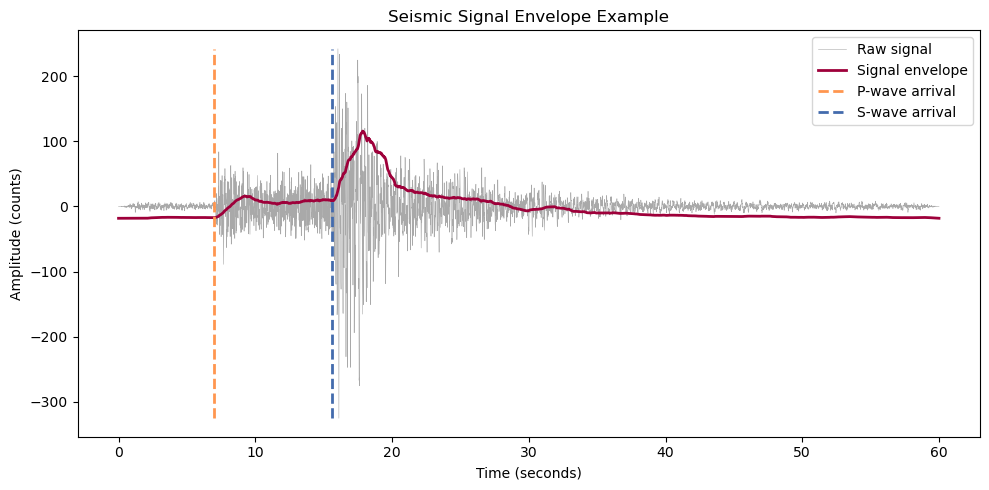

In [10]:
i = 57 # example trace
fig, ax = plt.subplots(1,1,figsize=(10,5))
sig = raw_signals[i][:,2]
ax.plot(np.linspace(0,60,6000), sig, color='darkgrey', linewidth=0.4, label='Raw signal')
ax.plot(np.linspace(0,60,6000), signal_envelopes[i], color='xkcd:cranberry', linewidth=2, label='Signal envelope')
p_wave = metadata.iloc[i]['p_arrival_sample']
s_wave = metadata.iloc[i]['s_arrival_sample']
ax.vlines(p_wave/100.0, sig.min(), sig.max(), color='xkcd:pastel orange', linewidth=2, linestyle='--', label='P-wave arrival')
ax.vlines(s_wave/100.0, sig.min(), sig.max(), color='xkcd:french blue', linewidth=2, linestyle='--', label='S-wave arrival')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Amplitude (counts)')
ax.set_title('Seismic Signal Envelope Example')
ax.legend()
plt.tight_layout()

### Create subsets of earthquake-only data (no noise samples)

In [11]:
earthquakes_indices = np.array(list(metadata[metadata['trace_category']=='earthquake_local'].index))
raw_signals_earthquakes_only = raw_signals[earthquakes_indices]
envelopes_earthquakes_only = signal_envelopes_resamp[earthquakes_indices]
metadata_earthquakes_only = metadata[metadata['trace_category']=='earthquake_local']

### Reshape signal envelopes so they have the correct format for input into the LSTM models

In [12]:
signal_envelopes_resamp = np.reshape(signal_envelopes_resamp, (signal_envelopes_resamp.shape[0], 1, signal_envelopes_resamp.shape[1]))
envelopes_earthquakes_only = np.reshape(envelopes_earthquakes_only, (envelopes_earthquakes_only.shape[0], 1, envelopes_earthquakes_only.shape[1]))

## Model training & evaluation

### 1. Classification LSTM model training & evaluation to predict whether signals are 'earthquake' or 'noise'

Epoch 1/100


/opt/miniconda3/envs/earthquake-detection/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.7230 - loss: 0.6706 - val_accuracy: 0.8423 - val_loss: 0.5262 - learning_rate: 1.0000e-05
Epoch 2/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8457 - loss: 0.4787 - val_accuracy: 0.8702 - val_loss: 0.3599 - learning_rate: 1.0000e-05
Epoch 3/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8747 - loss: 0.3497 - val_accuracy: 0.8936 - val_loss: 0.2953 - learning_rate: 1.0000e-05
Epoch 4/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8983 - loss: 0.2927 - val_accuracy: 0.9122 - val_loss: 0.2632 - learning_rate: 1.0000e-05
Epoch 5/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9150 - loss: 0.2610 - val_accuracy: 0.9243 - val_loss: 0.2413 - learning_rate: 1.0000e-05
Epoch 6/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9276 - loss: 0.2372 - val_accuracy: 0.9337 - val_loss: 0.2217 - learning_rate: 1.0000e-05
Epoch 7/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - a

2025-01-29 08:39:41.632709: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-01-29 08:39:41.752602: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Model baseline accuracy: 0.5199
 Model baseline precision: 0.5199
 Model baseline recall: 1.0
 Model baseline F1 score: 0.6841239555233897
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Model accuracy: 0.9706
 Model precision: 0.9719068693477005
 Model recall: 0.9715329871129064
 Model F1 score: 0.9717198922662562


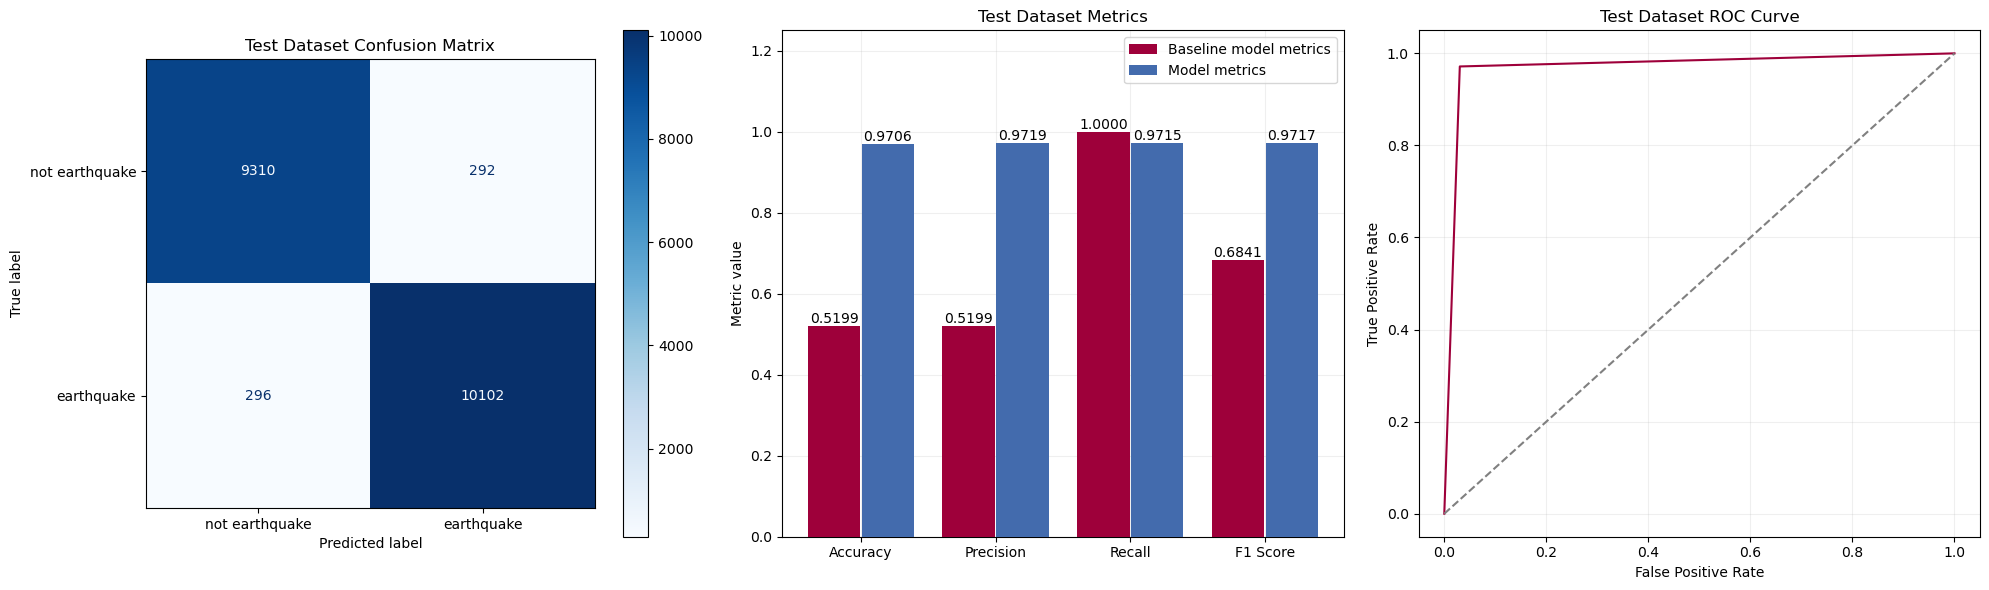

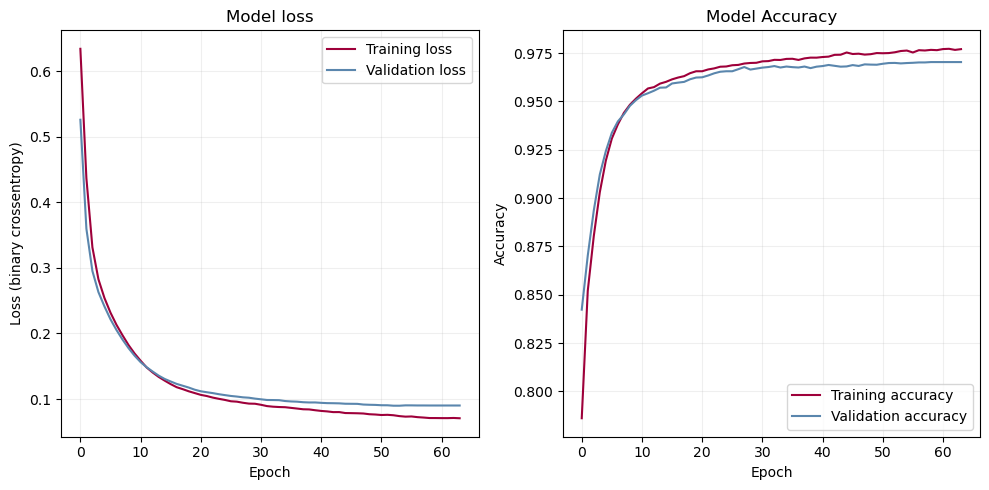

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 1, 64)          │        23,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1, 64)          │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,037 (812.65 KB)

 Trainable params: 69,345 (270.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 138,692 (541.77 KB)

In [13]:
# Set up model callbacks
epochs = 100
callbacks_c = architectures.callbacks_setup(model_tag='lstm_classification', epochs=epochs)

# Fit model
train_dataset_c, val_dataset_c, test_dataset_c = training_utils.prepare_datasets(imgs=signal_envelopes_resamp, labels=classifier_labels, batch_size=32)
input_shape = (signal_envelopes_resamp.shape[1], signal_envelopes_resamp.shape[2])
classifier_model = architectures.build_compile_classification_lstm(input_shape=input_shape, learning_rate=1e-5, loss='binary_crossentropy', metrics=['accuracy'])
classifier_history = classifier_model.fit(train_dataset_c, epochs=epochs, callbacks=callbacks_c, validation_data=val_dataset_c)

# Evaluate model and plot results
training_utils.evaluate_classification_model(classifier_model, train_dataset_c, test_dataset_c)
training_utils.plot_training_history(classifier_history)
classifier_model.summary()

### 2. Regression LSTM model training & evaluation for earthquake magnitude prediction

Epoch 1/100


/opt/miniconda3/envs/earthquake-detection/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1043/1043 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.8747 - mae: 1.0144 - val_loss: 0.6115 - val_mae: 0.5884 - learning_rate: 1.0000e-04
Epoch 2/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6277 - mae: 0.5970 - val_loss: 0.5505 - val_mae: 0.5634 - learning_rate: 1.0000e-04
Epoch 3/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5695 - mae: 0.5741 - val_loss: 0.5298 - val_mae: 0.5548 - learning_rate: 1.0000e-04
Epoch 4/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5452 - mae: 0.5627 - val_loss: 0.5169 - val_mae: 0.5509 - learning_rate: 1.0000e-04
Epoch 5/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5335 - mae: 0.5600 - val_loss: 0.5200 - val_mae: 0.5489 - learning_rate: 1.0000e-04
Epoch 6/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5363 - mae: 0.5595 - val_loss: 0.5220 - val_mae: 0.5500 - learning_rate: 1.0000e-04
Epoch 7/100
1027/1043 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5391 - mae: 0.5607
Epoch 7: ReduceLROnPlateau reducin

2025-01-29 08:42:04.689609: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 876us/step - loss: 0.4587 - mae: 0.4991
Test data MSE: 0.4692938029766083
Test data MAE: 0.5068281292915344
Getting predictions
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


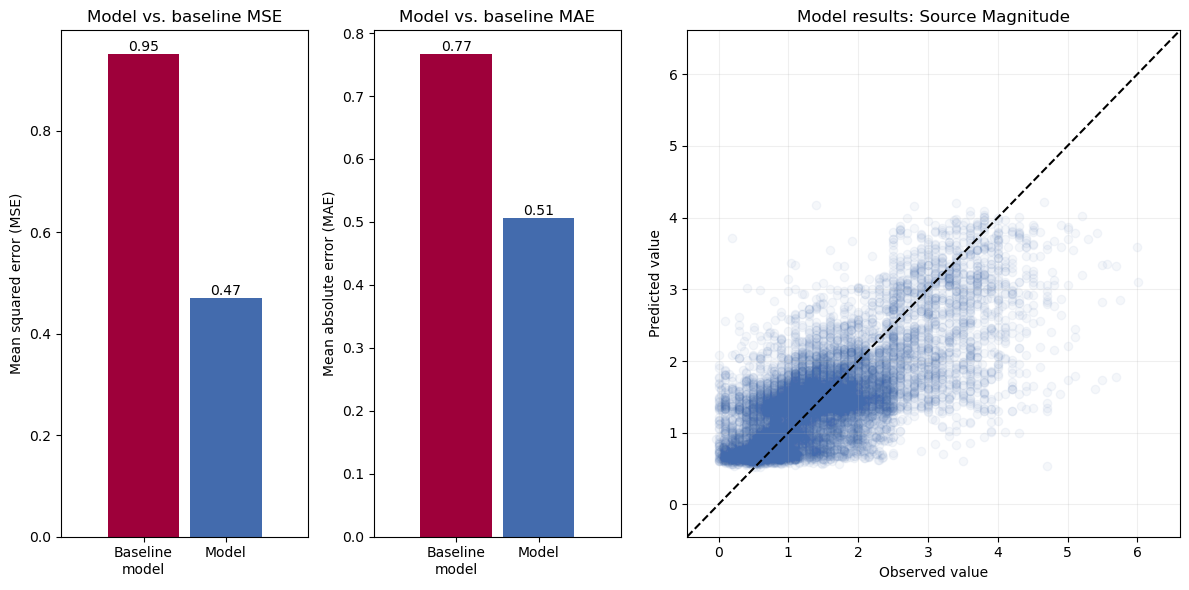

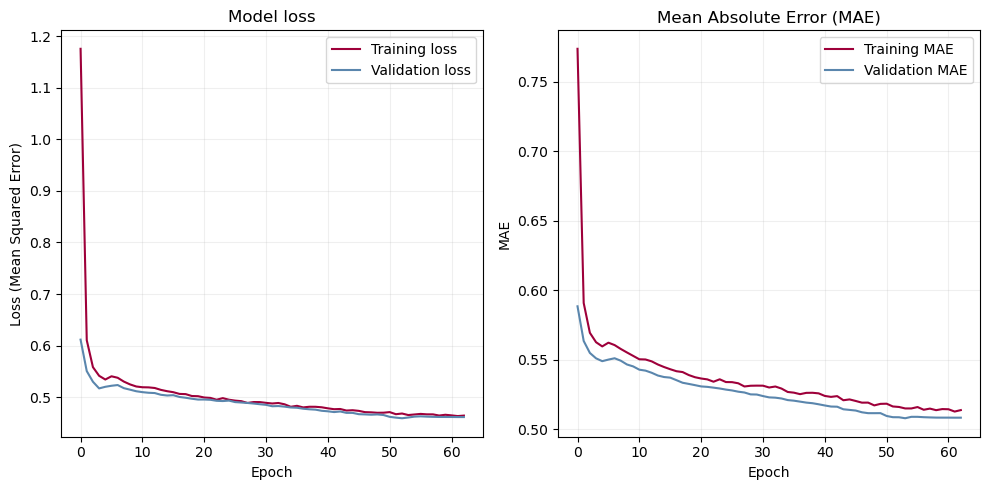

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 1, 32)          │        42,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,637 (615.77 KB)

 Trainable params: 52,545 (205.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 105,092 (410.52 KB)

In [14]:
# Set up model callbacks
epochs = 100
callbacks_mag = architectures.callbacks_setup(model_tag='lstm_regression_magnitude', epochs=epochs)

# Fit model
labels = np.array(metadata_earthquakes_only['source_magnitude'])
train_dataset_mag, val_dataset_mag, test_dataset_mag = training_utils.prepare_datasets(imgs=envelopes_earthquakes_only, labels=labels, batch_size=32)
input_shape = (envelopes_earthquakes_only.shape[1], envelopes_earthquakes_only.shape[2])
model_magnitude = architectures.build_compile_regression_lstm(input_shape=input_shape, learning_rate=1e-4, loss='mse', metrics=['mae'])
model_magnitude_history = model_magnitude.fit(train_dataset_mag, epochs=epochs, callbacks=callbacks_mag, validation_data=val_dataset_mag)

# Evaluate model and plot results
training_utils.evaluate_regression_model(model_magnitude, train_dataset_mag, test_dataset_mag, 'Source Magnitude', scaler=None)
training_utils.plot_training_history(model_magnitude_history)
model_magnitude.summary()

### 3. Regression LSTM model training & evaluation for earthquake p-wave arrival time prediction

Epoch 1/100


/opt/miniconda3/envs/earthquake-detection/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1043/1043 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 458299.9062 - mae: 653.5806 - val_loss: 373113.7812 - val_mae: 585.0085 - learning_rate: 1.0000e-04
Epoch 2/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 313149.5938 - mae: 528.5745 - val_loss: 155525.5156 - val_mae: 352.4873 - learning_rate: 1.0000e-04
Epoch 3/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 114005.6484 - mae: 285.9302 - val_loss: 41684.7812 - val_mae: 169.7465 - learning_rate: 1.0000e-04
Epoch 4/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 38270.0508 - mae: 161.8452 - val_loss: 24086.0000 - val_mae: 129.1812 - learning_rate: 1.0000e-04
Epoch 5/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 21574.6543 - mae: 115.8493 - val_loss: 11321.0234 - val_mae: 80.4286 - learning_rate: 1.0000e-04
Epoch 6/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 13507.8955 - mae: 87.3952 - val_loss: 8947.0254 - val_mae: 68.4945 - learning_rate: 1.0000e-04
Epoch 7/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s

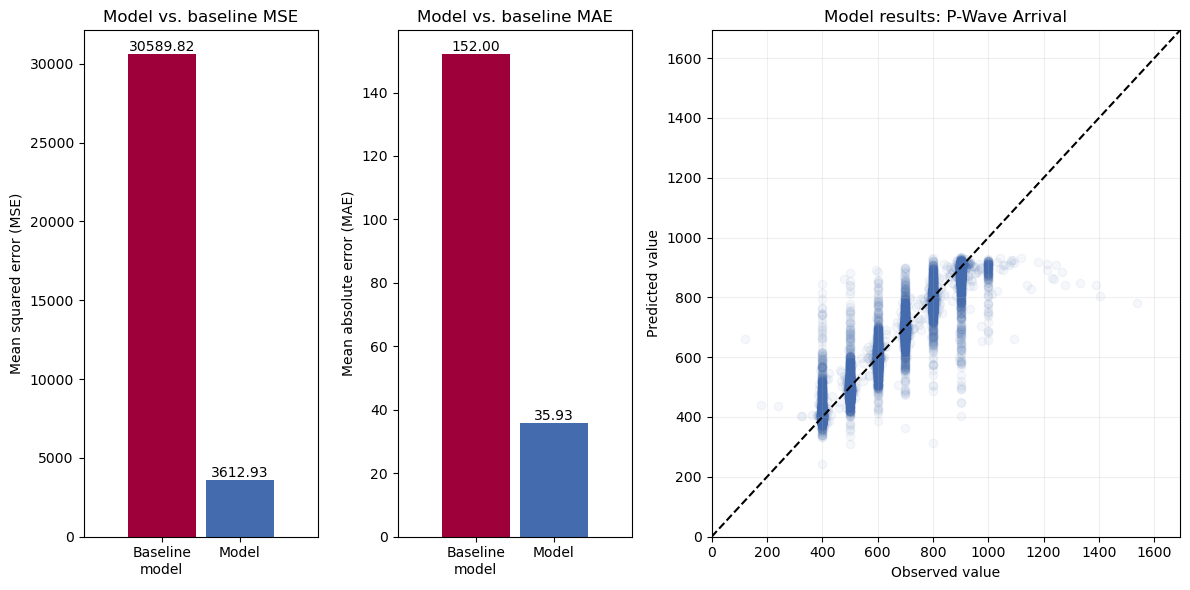

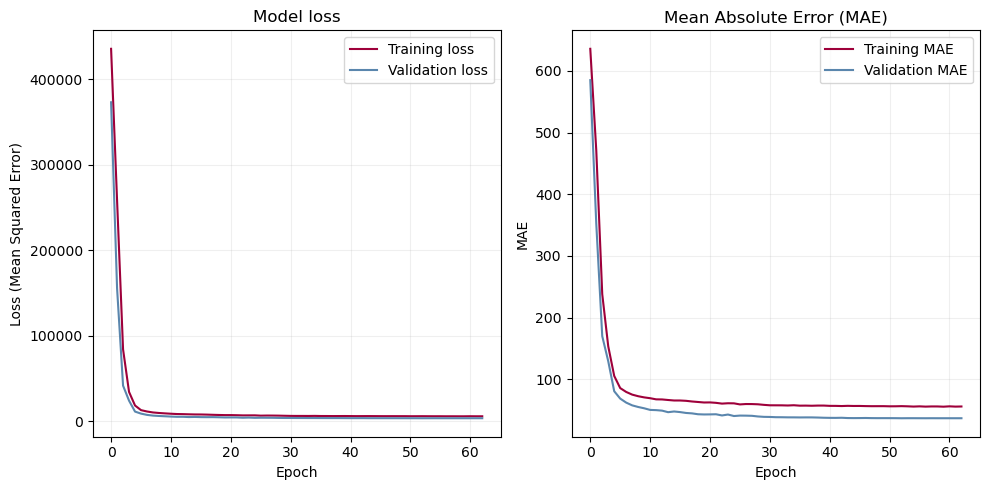

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 1, 32)          │        42,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,637 (615.77 KB)

 Trainable params: 52,545 (205.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 105,092 (410.52 KB)

In [15]:
# Set up model callbacks
epochs = 100
callbacks_pwave = architectures.callbacks_setup(model_tag='lstm_regression_pwave', epochs=epochs)

# Fit model
labels = np.array(metadata_earthquakes_only['p_arrival_sample'])
train_dataset_pwave, val_dataset_pwave, test_dataset_pwave = training_utils.prepare_datasets(imgs=envelopes_earthquakes_only, labels=labels, batch_size=32)
input_shape = (envelopes_earthquakes_only.shape[1], envelopes_earthquakes_only.shape[2])
model_pwave = architectures.build_compile_regression_lstm(input_shape=input_shape, learning_rate=1e-4, loss='mse', metrics=['mae'])
model_pwave_history = model_pwave.fit(train_dataset_pwave, epochs=epochs, callbacks=callbacks_pwave, validation_data=val_dataset_pwave)

# Evaluate model and plot results
training_utils.evaluate_regression_model(model_pwave, train_dataset_pwave, test_dataset_pwave, 'P-Wave Arrival', scaler=None)
training_utils.plot_training_history(model_pwave_history)
model_pwave.summary()

### 4. Regression LSTM model training & evaluation for earthquake s-wave arrival time prediction

Epoch 1/100


/opt/miniconda3/envs/earthquake-detection/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1043/1043 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 2145230.5000 - mae: 1331.1816 - val_loss: 1997672.1250 - val_mae: 1281.5306 - learning_rate: 1.0000e-04
Epoch 2/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1903842.5000 - mae: 1234.1276 - val_loss: 1482329.3750 - val_mae: 1059.9745 - learning_rate: 1.0000e-04
Epoch 3/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 1333659.3750 - mae: 971.9254 - val_loss: 843523.6875 - val_mae: 704.8745 - learning_rate: 1.0000e-04
Epoch 4/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 737019.6250 - mae: 621.4895 - val_loss: 430571.6562 - val_mae: 431.1112 - learning_rate: 1.0000e-04
Epoch 5/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 397133.8125 - mae: 394.5460 - val_loss: 225190.4375 - val_mae: 253.8844 - learning_rate: 1.0000e-04
Epoch 6/100
1043/1043 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 227895.9844 - mae: 262.1315 - val_loss: 143698.4219 - val_mae: 191.1246 - learning_rate: 1.0000e-04
Epoch 7/100
1043/1043 ━━━

2025-01-29 08:45:53.587328: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - loss: 42851.9453 - mae: 108.2734
Test data MSE: 44034.1953125
Test data MAE: 107.56795501708984
Getting predictions
326/326 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


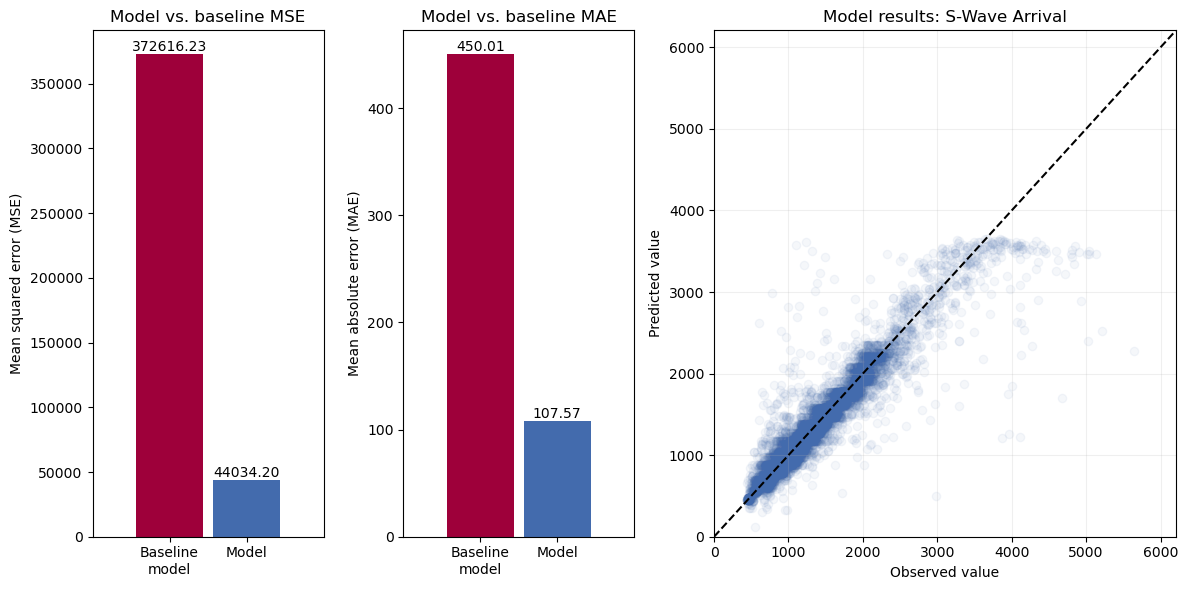

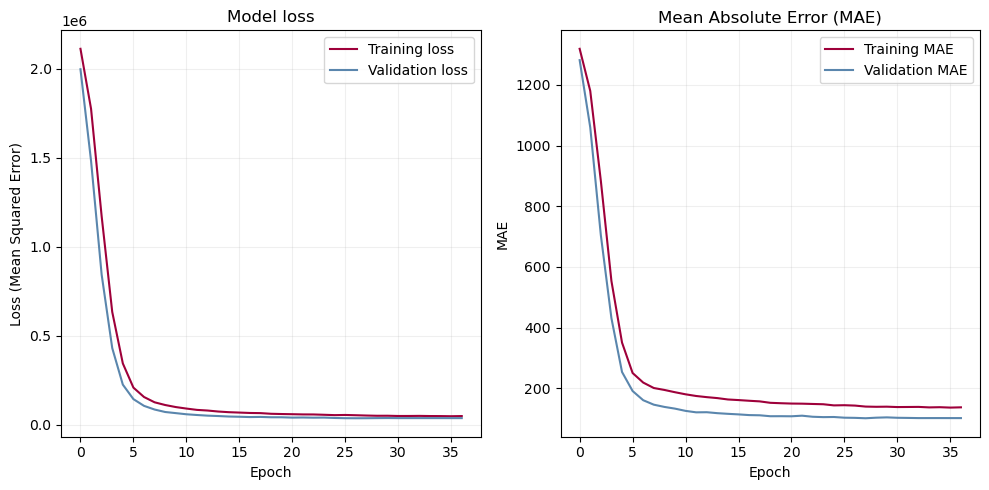

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 1, 32)          │        42,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 157,637 (615.77 KB)

 Trainable params: 52,545 (205.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 105,092 (410.52 KB)

In [16]:
# Set up model callbacks
epochs = 100
callbacks_swave = architectures.callbacks_setup(model_tag='lstm_regression_swave', epochs=epochs)

# Fit model
labels = np.array(metadata_earthquakes_only['s_arrival_sample'])
train_dataset_swave, val_dataset_swave, test_dataset_swave = training_utils.prepare_datasets(imgs=envelopes_earthquakes_only, labels=labels, batch_size=32)
input_shape = (envelopes_earthquakes_only.shape[1], envelopes_earthquakes_only.shape[2])
model_swave = architectures.build_compile_regression_lstm(input_shape=input_shape, learning_rate=1e-4, loss='mse', metrics=['mae'])
model_swave_history = model_swave.fit(train_dataset_swave, epochs=epochs, callbacks=callbacks_swave, validation_data=val_dataset_swave)

# Evaluate model and plot results
training_utils.evaluate_regression_model(model_swave, train_dataset_swave, test_dataset_swave, 'S-Wave Arrival', scaler=None)
training_utils.plot_training_history(model_swave_history)
model_swave.summary()